In [1]:
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.backends.mps.is_available()

True

# Load the Cora dataset

In [3]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [4]:
print(dataset)
print("No. of graphs: ", len(dataset))
print("No. of classes: ", dataset.num_classes)
print("No. of node features: ", dataset.num_node_features)
print("No. of edge features: ", dataset.num_edge_features)
print("No. of nodes: ", dataset[0].num_nodes)
print("No. of edges: ", dataset[0].num_edges)

Cora()
No. of graphs:  1
No. of classes:  7
No. of node features:  1433
No. of edge features:  0
No. of nodes:  2708
No. of edges:  10556


# Load the first graph

In [5]:
data = dataset[0]

In [6]:
type(data)

torch_geometric.data.data.Data

In [7]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [8]:
data.test_mask

tensor([False, False, False,  ...,  True,  True,  True])

In [9]:
np.unique(data.y.numpy())

array([0, 1, 2, 3, 4, 5, 6])

In [10]:
data.x.shape  # (no. of nodes, no. of features)

torch.Size([2708, 1433])

In [11]:
data.edge_index.shape

torch.Size([2, 10556])

In [12]:
adj = torch_geometric.utils.to_dense_adj(data.edge_index)[0]
adj

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [14]:
adj = adj.to('mps')

In [15]:
adj += torch.eye(len(adj)).to('mps')
adj

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]], device='mps:0')

In [16]:
adj_gpu = adj

In [53]:
adj = adj_gpu.cpu()

In [18]:
import pandas as pd
adj_df = pd.DataFrame(adj.cpu())
adj_df.to_csv("Cora_Adj.csv")

In [19]:
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true).item()/len(y_true)

# 1. MLP

In [20]:
from torch.nn import Linear
import torch.nn.functional as F

In [27]:
class MLP(torch.nn.Module):
    def __init__(self, dim_in, dim_h1, dim_h2, dim_out):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h1) # Linear layer 1
        self.linear2 = Linear(dim_h1, dim_h2) # Linear layer 2
        self.linear3 = Linear(dim_h2, dim_out) # layer 3
        
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x) # activation function
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        return F.log_softmax(x, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss() # Loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        self.train()
        
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)  # calls the model (self) and performs a forward pass
            
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            train_accuracies.append(acc)
            
            # validation loss and accuracy
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)
            
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')
            
        test_acc = self.test(data)
        
        # After training, plot the loss and accuracy curves
        self.plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies,test_acc)
    
    def plot_training_curves(self, train_losses, val_losses, train_accuracies, val_accuracies,test_acc):
        # Plot loss curves
        epochs = range(len(train_losses))
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        
         # Plot test accuracy as a horizontal line
        plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc*100:.2f}%')
        
        plt.title('Accuracy Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Set y-axis ticks to increments of 0.1
        plt.yticks(np.arange(0, 1.1, 0.1))

        plt.tight_layout()
        plt.show()
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [28]:
mlp = MLP(dataset.num_features, 128, 64, dataset.num_classes)
mlp

MLP(
  (linear1): Linear(in_features=1433, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=7, bias=True)
)

Epoch   0 | Train Loss: 1.947 | Train Acc: 14.29% | Val Loss: 1.96 | Val Acc: 15.60%
Epoch   1 | Train Loss: 1.869 | Train Acc: 83.57% | Val Loss: 1.94 | Val Acc: 26.60%
Epoch   2 | Train Loss: 1.694 | Train Acc: 99.29% | Val Loss: 1.90 | Val Acc: 39.60%
Epoch   3 | Train Loss: 1.372 | Train Acc: 99.29% | Val Loss: 1.83 | Val Acc: 38.40%
Epoch   4 | Train Loss: 0.938 | Train Acc: 99.29% | Val Loss: 1.75 | Val Acc: 38.60%
Epoch   5 | Train Loss: 0.513 | Train Acc: 100.00% | Val Loss: 1.62 | Val Acc: 46.40%
Epoch   6 | Train Loss: 0.233 | Train Acc: 100.00% | Val Loss: 1.47 | Val Acc: 53.60%
Epoch   7 | Train Loss: 0.108 | Train Acc: 100.00% | Val Loss: 1.38 | Val Acc: 56.00%
Epoch   8 | Train Loss: 0.055 | Train Acc: 100.00% | Val Loss: 1.40 | Val Acc: 56.20%
Epoch   9 | Train Loss: 0.028 | Train Acc: 100.00% | Val Loss: 1.52 | Val Acc: 52.00%
Epoch  10 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 1.74 | Val Acc: 50.80%
Epoch  11 | Train Loss: 0.006 | Train Acc: 100.00% | Val Lo

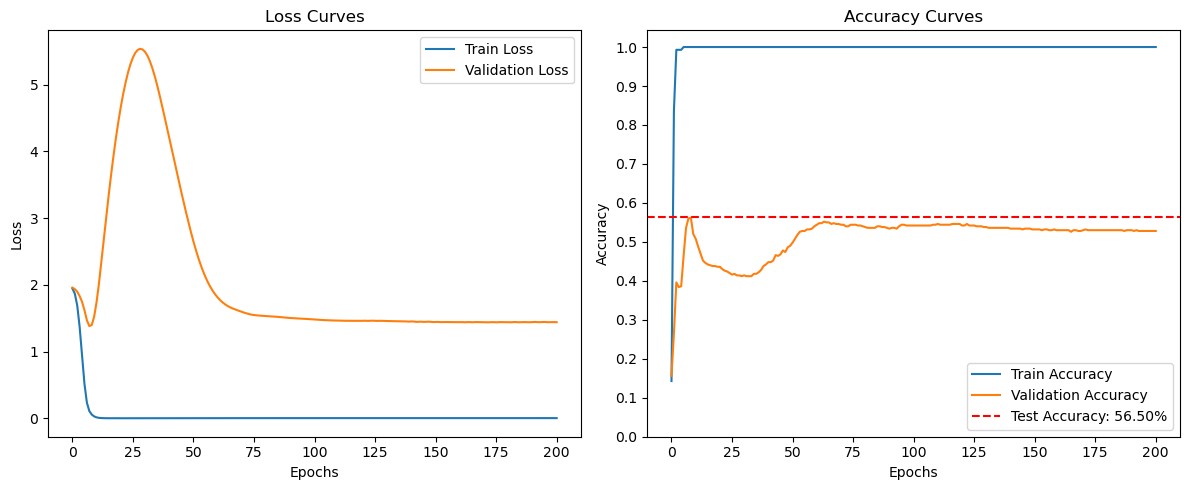

In [29]:
mlp.fit(data, epochs=200)

In [30]:
mlp.test(data)

0.565

In [31]:
mlp_gpu = MLP(dataset.num_features, 128, 64, dataset.num_classes).to('mps')

In [32]:
data_gpu = data.to('mps')

In [33]:
mlp_gpu

MLP(
  (linear1): Linear(in_features=1433, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=7, bias=True)
)

Epoch   0 | Train Loss: 1.949 | Train Acc: 14.29% | Val Loss: 1.96 | Val Acc: 15.60%
Epoch   1 | Train Loss: 1.868 | Train Acc: 65.71% | Val Loss: 1.93 | Val Acc: 23.60%
Epoch   2 | Train Loss: 1.691 | Train Acc: 97.14% | Val Loss: 1.88 | Val Acc: 39.60%
Epoch   3 | Train Loss: 1.376 | Train Acc: 98.57% | Val Loss: 1.78 | Val Acc: 48.00%
Epoch   4 | Train Loss: 0.962 | Train Acc: 98.57% | Val Loss: 1.68 | Val Acc: 46.00%
Epoch   5 | Train Loss: 0.552 | Train Acc: 100.00% | Val Loss: 1.55 | Val Acc: 47.80%
Epoch   6 | Train Loss: 0.262 | Train Acc: 100.00% | Val Loss: 1.44 | Val Acc: 51.40%
Epoch   7 | Train Loss: 0.120 | Train Acc: 100.00% | Val Loss: 1.39 | Val Acc: 53.40%
Epoch   8 | Train Loss: 0.060 | Train Acc: 100.00% | Val Loss: 1.41 | Val Acc: 52.60%
Epoch   9 | Train Loss: 0.030 | Train Acc: 100.00% | Val Loss: 1.50 | Val Acc: 52.20%
Epoch  10 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 1.67 | Val Acc: 52.40%
Epoch  11 | Train Loss: 0.006 | Train Acc: 100.00% | Val Lo

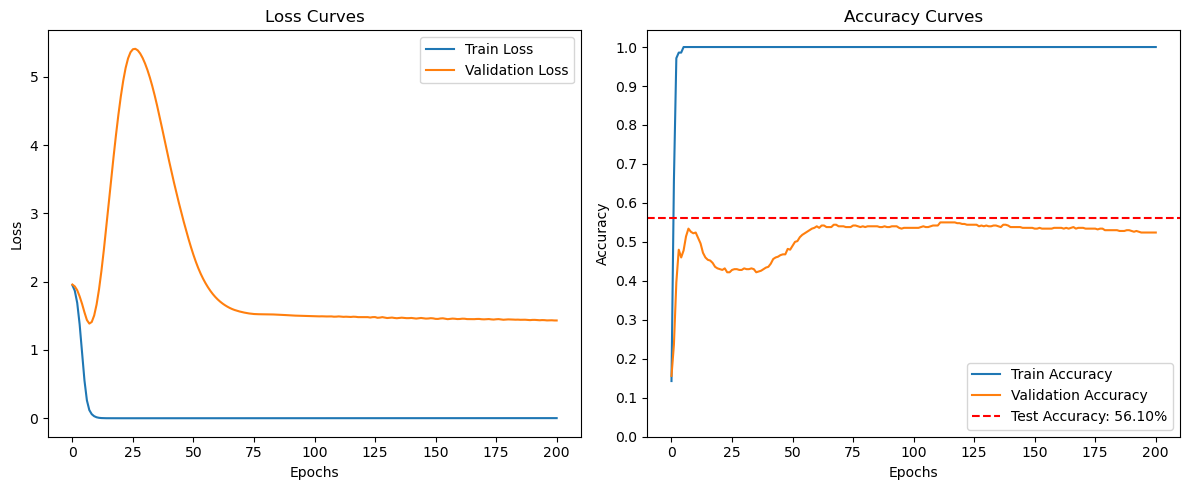

In [34]:
mlp_gpu.fit(data_gpu, epochs=200)

In [35]:
mlp_gpu.test(data_gpu)

0.561

## Summary of MLP

| Device  |  Train Acc  | Val Acc | Test Acc |
|:-------:|:-----------:|:-------:|:--------:|
|   CPU   |    100%     |  52.8%  |  56.5%   |
|   GPU   |    100%     |  52.4%  |  56.1%   |

# Vanilla GNN

In [36]:
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = torch.nn.Linear(dim_in, dim_out, bias=False)
    
    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

In [37]:
 class VanillaGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)
    
    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        self.train()
        
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adj)
            
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            train_accuracies.append(acc)
            
            # validation loss and accuracy
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)
            
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')
        
        test_acc = self.test(data)
        
          # After training, plot the loss and accuracy curves
        self.plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies,test_acc)
    
    def plot_training_curves(self, train_losses, val_losses, train_accuracies, val_accuracies,test_acc):
        # Plot loss curves
        epochs = range(len(train_losses))
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        
         # Plot test accuracy as a horizontal line
        plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc*100:.2f}%')
        
        plt.title('Accuracy Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Set y-axis ticks to increments of 0.1
        plt.yticks(np.arange(0, 1.1, 0.1))

        plt.tight_layout()
        plt.show()
    
    @torch.no_grad()      
    def test(self, data):
        self.eval()
        out = self(data.x,adj)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [54]:
v_gnn = VanillaGNN(dataset.num_features, 64, dataset.num_classes)
v_gnn

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=64, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=64, out_features=7, bias=False)
  )
)

Epoch   0 | Train Loss: 1.909 | Train Acc: 15.00% | Val Loss: 1.86 | Val Acc: 19.00%
Epoch   1 | Train Loss: 1.580 | Train Acc: 51.43% | Val Loss: 2.16 | Val Acc: 32.00%
Epoch   2 | Train Loss: 0.972 | Train Acc: 72.14% | Val Loss: 1.55 | Val Acc: 63.40%
Epoch   3 | Train Loss: 0.981 | Train Acc: 83.57% | Val Loss: 1.67 | Val Acc: 61.60%
Epoch   4 | Train Loss: 0.675 | Train Acc: 90.71% | Val Loss: 1.33 | Val Acc: 71.60%
Epoch   5 | Train Loss: 0.519 | Train Acc: 94.29% | Val Loss: 1.25 | Val Acc: 71.40%
Epoch   6 | Train Loss: 0.379 | Train Acc: 94.29% | Val Loss: 1.36 | Val Acc: 70.40%
Epoch   7 | Train Loss: 0.256 | Train Acc: 92.14% | Val Loss: 1.47 | Val Acc: 70.00%
Epoch   8 | Train Loss: 0.184 | Train Acc: 97.14% | Val Loss: 1.55 | Val Acc: 70.20%
Epoch   9 | Train Loss: 0.117 | Train Acc: 98.57% | Val Loss: 1.63 | Val Acc: 71.40%
Epoch  10 | Train Loss: 0.091 | Train Acc: 98.57% | Val Loss: 1.73 | Val Acc: 72.00%
Epoch  11 | Train Loss: 0.072 | Train Acc: 99.29% | Val Loss: 1.8

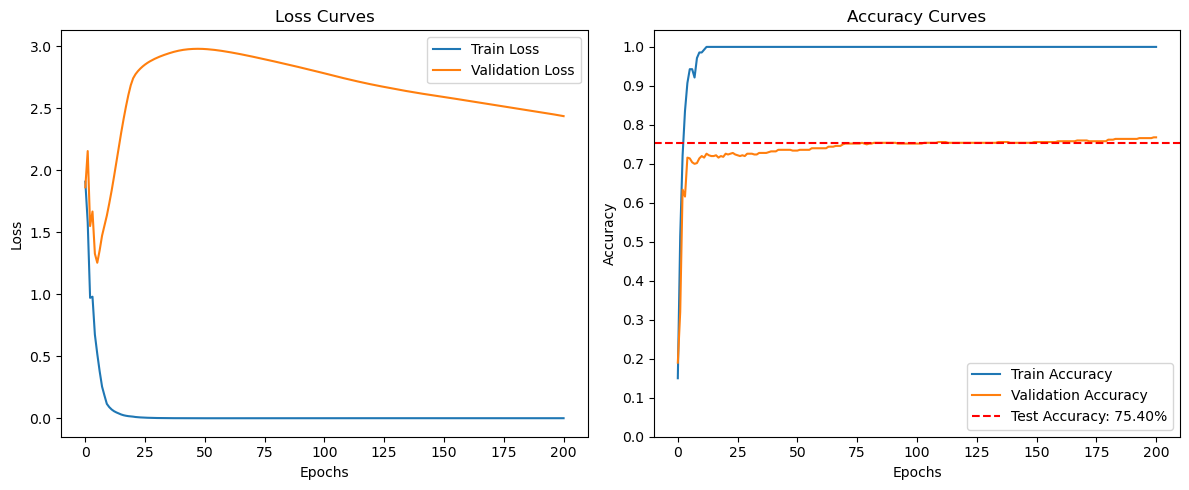

In [55]:
v_gnn.fit(data.cpu(), epochs=200)

In [56]:
v_gnn.test(data.cpu())

0.754

In [45]:
v_gnn_gpu = VanillaGNN(dataset.num_features, 64, dataset.num_classes).to('mps')
v_gnn_gpu

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=64, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=64, out_features=7, bias=False)
  )
)

In [57]:
adj = adj_gpu

Epoch   0 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 2.60 | Val Acc: 74.00%
Epoch   1 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 2.40 | Val Acc: 74.20%
Epoch   2 | Train Loss: 0.341 | Train Acc: 95.00% | Val Loss: 2.56 | Val Acc: 73.40%
Epoch   3 | Train Loss: 0.910 | Train Acc: 90.00% | Val Loss: 4.67 | Val Acc: 56.60%
Epoch   4 | Train Loss: 0.179 | Train Acc: 99.29% | Val Loss: 2.80 | Val Acc: 72.80%
Epoch   5 | Train Loss: 0.023 | Train Acc: 99.29% | Val Loss: 2.72 | Val Acc: 72.00%
Epoch   6 | Train Loss: 0.265 | Train Acc: 97.14% | Val Loss: 2.84 | Val Acc: 69.40%
Epoch   7 | Train Loss: 0.270 | Train Acc: 96.43% | Val Loss: 3.13 | Val Acc: 67.40%
Epoch   8 | Train Loss: 0.050 | Train Acc: 99.29% | Val Loss: 3.05 | Val Acc: 70.20%
Epoch   9 | Train Loss: 0.026 | Train Acc: 99.29% | Val Loss: 3.06 | Val Acc: 71.20%
Epoch  10 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 3.11 | Val Acc: 73.00%
Epoch  11 | Train Loss: 0.072 | Train Acc: 98.57% | Val Loss: 

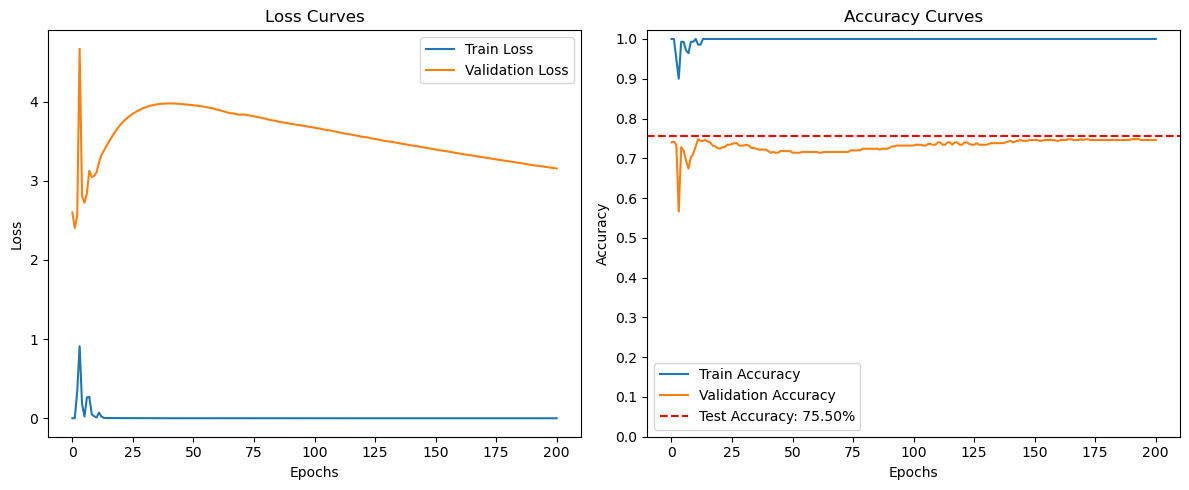

In [58]:
v_gnn_gpu.fit(data.to('mps'), epochs=200)

In [59]:
v_gnn_gpu.test(data.to('mps'))

0.755

## Summary of Vanilla GNN

| Device  |  Train Acc  | Val Acc | Test Acc |
|:-------:|:-----------:|:-------:|:--------:|
|   CPU   |    100%     |  76.8%  |  75.4%   |
|   GPU   |    100%     |  74.6%  |  75.5%   |

In [101]:
y = v_gnn_gpu(data.to('mps').x, adj)
y

tensor([[-1.1494e+01, -8.7916e+00, -8.4801e+00,  ..., -1.1457e+01,
         -1.3799e+01, -1.4140e+01],
        [-1.1812e+01, -1.4686e+01, -1.5133e+01,  ..., -8.1062e-06,
         -1.7736e+01, -1.8839e+01],
        [-2.9630e+01, -1.9296e+01, -1.1361e+01,  ..., -1.2517e-05,
         -3.6367e+01, -3.8791e+01],
        ...,
        [-1.3631e+00, -1.7010e+00, -2.9240e+00,  ..., -3.0447e+00,
         -1.7728e+00, -2.0846e+00],
        [-9.4281e+00, -6.1774e+00, -5.5660e+00,  ..., -6.5373e+00,
         -1.2713e+01, -1.3374e+01],
        [-2.5527e+01, -1.5037e+01, -1.2339e+01,  ..., -2.0282e+01,
         -3.1518e+01, -3.4331e+01]], device='mps:0',
       grad_fn=<LogSoftmaxBackward0>)

In [104]:
y.argmax(dim=1)

tensor([3, 4, 4,  ..., 0, 3, 3], device='mps:0')

In [105]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3], device='mps:0')

# GCN

In [60]:
from torch_geometric.nn import GCNConv

In [61]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
    
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        self.train()
        
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            
            loss = criterion(out[data.train_mask],data.y[data.train_mask]) 
            acc = accuracy(out[data.train_mask].argmax(dim=1),data.y[data.train_mask])
            
            train_losses.append(loss.item())
            train_accuracies.append(acc)
            
            loss.backward()
            optimizer.step()
            
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)
            
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')
        
        test_acc = self.test(data)
        
          # After training, plot the loss and accuracy curves
        self.plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies,test_acc)
    
    def plot_training_curves(self, train_losses, val_losses, train_accuracies, val_accuracies,test_acc):
        # Plot loss curves
        epochs = range(len(train_losses))
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        
         # Plot test accuracy as a horizontal line
        plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc*100:.2f}%')
        
        plt.title('Accuracy Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Set y-axis ticks to increments of 0.1
        plt.yticks(np.arange(0, 1.1, 0.1))

        plt.tight_layout()
        plt.show()
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [62]:
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
gcn

GCN(
  (gcn1): GCNConv(1433, 64)
  (gcn2): GCNConv(64, 7)
)

Epoch   0 | Train Loss: 1.940 | Train Acc: 18.57% | Val Loss: 1.96 | Val Acc: 10.40%
Epoch   1 | Train Loss: 1.650 | Train Acc: 89.29% | Val Loss: 1.81 | Val Acc: 52.00%
Epoch   2 | Train Loss: 1.331 | Train Acc: 92.14% | Val Loss: 1.64 | Val Acc: 60.20%
Epoch   3 | Train Loss: 1.022 | Train Acc: 93.57% | Val Loss: 1.47 | Val Acc: 62.80%
Epoch   4 | Train Loss: 0.755 | Train Acc: 97.14% | Val Loss: 1.30 | Val Acc: 68.60%
Epoch   5 | Train Loss: 0.537 | Train Acc: 98.57% | Val Loss: 1.13 | Val Acc: 75.20%
Epoch   6 | Train Loss: 0.374 | Train Acc: 98.57% | Val Loss: 0.99 | Val Acc: 77.80%
Epoch   7 | Train Loss: 0.257 | Train Acc: 99.29% | Val Loss: 0.88 | Val Acc: 78.60%
Epoch   8 | Train Loss: 0.177 | Train Acc: 100.00% | Val Loss: 0.80 | Val Acc: 79.60%
Epoch   9 | Train Loss: 0.122 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 78.40%
Epoch  10 | Train Loss: 0.085 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc: 77.60%
Epoch  11 | Train Loss: 0.060 | Train Acc: 100.00% | Val Loss:

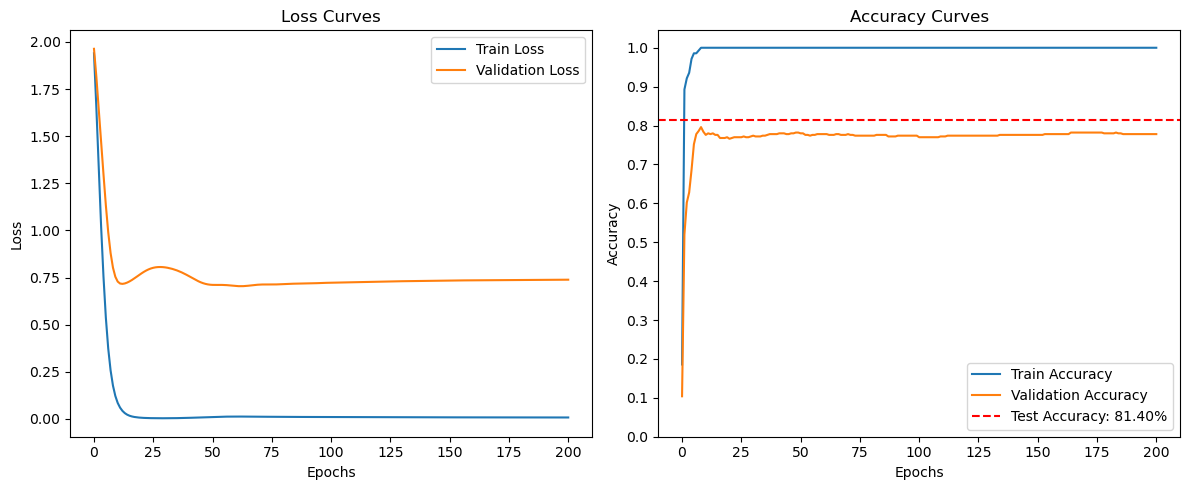

In [63]:
gcn.fit(data.cpu(), epochs=200)

In [64]:
gcn.test(data.cpu())

0.814

In [65]:
gcn_gpu = GCN(dataset.num_features, 64, dataset.num_classes).to('mps')
gcn_gpu

GCN(
  (gcn1): GCNConv(1433, 64)
  (gcn2): GCNConv(64, 7)
)

Epoch   0 | Train Loss: 1.952 | Train Acc: 11.43% | Val Loss: 1.96 | Val Acc: 7.60%
Epoch   1 | Train Loss: 1.671 | Train Acc: 92.86% | Val Loss: 1.83 | Val Acc: 59.40%
Epoch   2 | Train Loss: 1.354 | Train Acc: 96.43% | Val Loss: 1.67 | Val Acc: 68.20%
Epoch   3 | Train Loss: 1.031 | Train Acc: 97.86% | Val Loss: 1.49 | Val Acc: 68.20%
Epoch   4 | Train Loss: 0.756 | Train Acc: 97.86% | Val Loss: 1.31 | Val Acc: 70.20%
Epoch   5 | Train Loss: 0.538 | Train Acc: 98.57% | Val Loss: 1.14 | Val Acc: 75.00%
Epoch   6 | Train Loss: 0.374 | Train Acc: 98.57% | Val Loss: 0.99 | Val Acc: 76.80%
Epoch   7 | Train Loss: 0.256 | Train Acc: 98.57% | Val Loss: 0.88 | Val Acc: 78.80%
Epoch   8 | Train Loss: 0.175 | Train Acc: 98.57% | Val Loss: 0.79 | Val Acc: 79.40%
Epoch   9 | Train Loss: 0.120 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 79.40%
Epoch  10 | Train Loss: 0.082 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 79.80%
Epoch  11 | Train Loss: 0.057 | Train Acc: 100.00% | Val Loss: 0

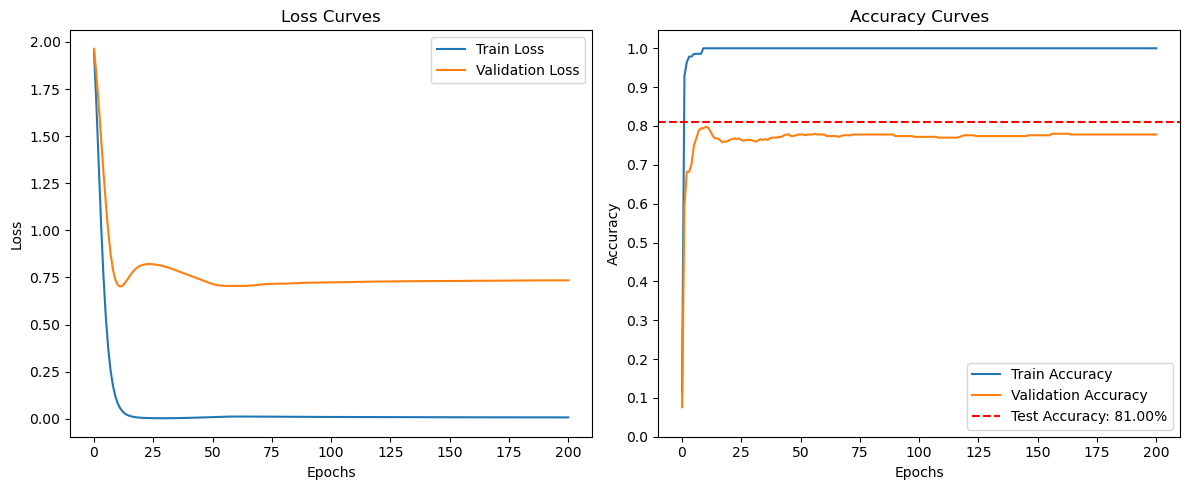

In [66]:
gcn_gpu.fit(data.to('mps'), epochs=200)

In [67]:
gcn_gpu.test(data.to('mps'))

0.81

## Summary of GCN

| Device  |  Train Acc  | Val Acc | Test Acc |
|:-------:|:-----------:|:-------:|:--------:|
|   CPU   |    100%     |  77.8%  |  81.4%   |
|   GPU   |    100%     |  77.8%  |   81%    |

# GAT

In [68]:
from torch_geometric.nn import GATv2Conv

In [77]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=8)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=0.01)
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            
            train_losses.append(loss.item())
            train_accuracies.append(acc)
            
            loss.backward()
            optimizer.step()
            
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)
            
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')
        
        test_acc = self.test(data)
        
          # After training, plot the loss and accuracy curves
        self.plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies,test_acc)
    
    def plot_training_curves(self, train_losses, val_losses, train_accuracies, val_accuracies,test_acc):
        # Plot loss curves
        epochs = range(len(train_losses))
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        
         # Plot test accuracy as a horizontal line
        plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc*100:.2f}%')
        
        plt.title('Accuracy Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Set y-axis ticks to increments of 0.1
        plt.yticks(np.arange(0, 1.1, 0.1))

        plt.tight_layout()
        plt.show()
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc


In [78]:
gat = GAT(dataset.num_features, 64, dataset.num_classes)
gat

GAT(
  (gat1): GATv2Conv(1433, 64, heads=8)
  (gat2): GATv2Conv(512, 7, heads=1)
)

Epoch   0 | Train Loss: 1.947 | Train Acc: 15.00% | Val Loss: 1.95 | Val Acc: 12.60%
Epoch   1 | Train Loss: 1.866 | Train Acc: 32.14% | Val Loss: 1.91 | Val Acc: 26.00%
Epoch   2 | Train Loss: 1.775 | Train Acc: 57.14% | Val Loss: 1.86 | Val Acc: 35.20%
Epoch   3 | Train Loss: 1.671 | Train Acc: 73.57% | Val Loss: 1.80 | Val Acc: 46.60%
Epoch   4 | Train Loss: 1.604 | Train Acc: 80.71% | Val Loss: 1.76 | Val Acc: 53.00%
Epoch   5 | Train Loss: 1.531 | Train Acc: 80.71% | Val Loss: 1.72 | Val Acc: 57.80%
Epoch   6 | Train Loss: 1.451 | Train Acc: 86.43% | Val Loss: 1.66 | Val Acc: 63.00%
Epoch   7 | Train Loss: 1.356 | Train Acc: 90.00% | Val Loss: 1.62 | Val Acc: 62.00%
Epoch   8 | Train Loss: 1.305 | Train Acc: 91.43% | Val Loss: 1.58 | Val Acc: 65.00%
Epoch   9 | Train Loss: 1.249 | Train Acc: 90.71% | Val Loss: 1.55 | Val Acc: 69.80%
Epoch  10 | Train Loss: 1.170 | Train Acc: 94.29% | Val Loss: 1.50 | Val Acc: 71.20%
Epoch  11 | Train Loss: 1.101 | Train Acc: 94.29% | Val Loss: 1.4

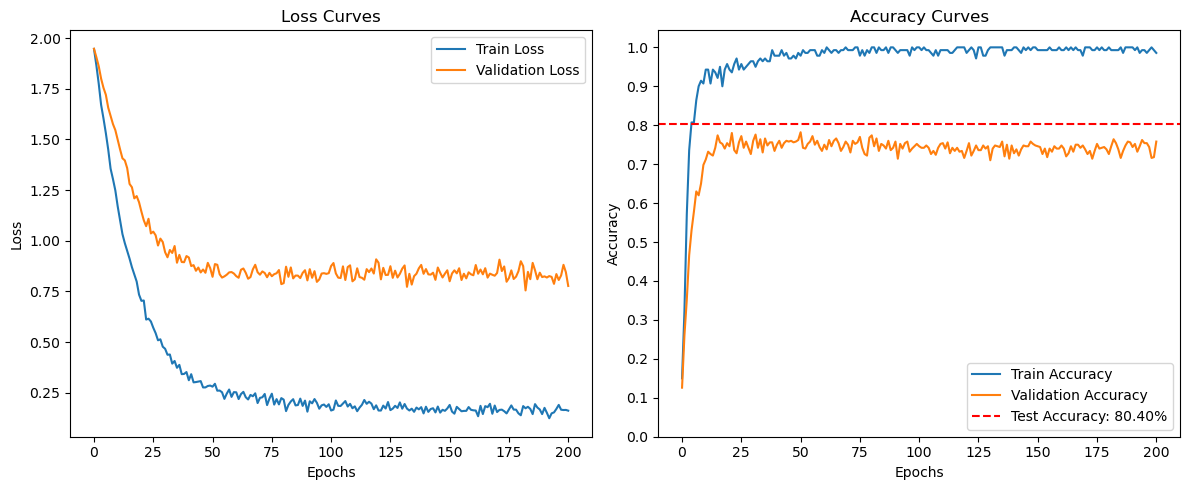

In [79]:
gat.fit(data.cpu(), epochs=200)

In [80]:
gat.test(data.cpu())

0.804

In [81]:
gat_gpu = GAT(dataset.num_features, 64, dataset.num_classes).to('mps')
gat_gpu

GAT(
  (gat1): GATv2Conv(1433, 64, heads=8)
  (gat2): GATv2Conv(512, 7, heads=1)
)

In [82]:
gat_gpu.fit(data.to('mps'), epochs=200)

NotImplementedError: The operator 'aten::scatter_reduce.two_out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

## Summary of GAT

|  Device  | Train Acc | Val Acc | Test Acc |
|:--------:|:---------:|:-------:|:--------:|
|   CPU    |  98.57%   |  75.8%  |  80.4%   |
|   GPU    |     -     |    -    |    -     |
| Tesla T4 |  97.86%   |  71.2%  |  78.7%   |

# GraphSAGE

In [83]:
from torch_geometric.nn import SAGEConv

In [84]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.conv1 = SAGEConv(dim_in, dim_h, aggr="mean")
        self.conv2 = SAGEConv(dim_h, dim_out, aggr="mean")
    
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            train_accuracies.append(acc)
            
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)
            
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')
        
        test_acc = self.test(data)
        
          # After training, plot the loss and accuracy curves
        self.plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies,test_acc)
    
    def plot_training_curves(self, train_losses, val_losses, train_accuracies, val_accuracies,test_acc):
        # Plot loss curves
        epochs = range(len(train_losses))
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        
         # Plot test accuracy as a horizontal line
        plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc*100:.2f}%')
        
        plt.title('Accuracy Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Set y-axis ticks to increments of 0.1
        plt.yticks(np.arange(0, 1.1, 0.1))

        plt.tight_layout()
        plt.show()
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc
    

In [85]:
g_sage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
g_sage

GraphSAGE(
  (conv1): SAGEConv(1433, 64, aggr=mean)
  (conv2): SAGEConv(64, 7, aggr=mean)
)

Epoch   0 | Train Loss: 1.946 | Train Acc: 18.57% | Val Loss: 1.97 | Val Acc: 16.60%
Epoch   1 | Train Loss: 1.537 | Train Acc: 99.29% | Val Loss: 1.82 | Val Acc: 58.60%
Epoch   2 | Train Loss: 0.995 | Train Acc: 98.57% | Val Loss: 1.60 | Val Acc: 53.80%
Epoch   3 | Train Loss: 0.531 | Train Acc: 99.29% | Val Loss: 1.37 | Val Acc: 60.00%
Epoch   4 | Train Loss: 0.230 | Train Acc: 100.00% | Val Loss: 1.11 | Val Acc: 74.40%
Epoch   5 | Train Loss: 0.095 | Train Acc: 100.00% | Val Loss: 0.92 | Val Acc: 77.40%
Epoch   6 | Train Loss: 0.040 | Train Acc: 100.00% | Val Loss: 0.82 | Val Acc: 78.60%
Epoch   7 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.76 | Val Acc: 78.40%
Epoch   8 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 78.00%
Epoch   9 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.80%
Epoch  10 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.77 | Val Acc: 77.00%
Epoch  11 | Train Loss: 0.001 | Train Acc: 100.00% | Val L

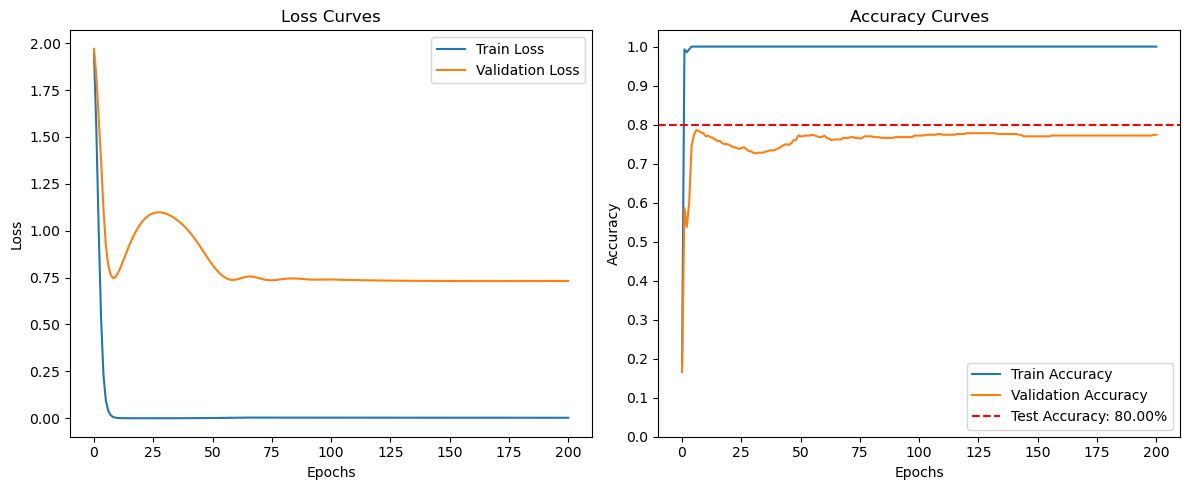

In [86]:
g_sage.fit(data.cpu(), epochs=200)

In [87]:
g_sage.test(data.cpu())

0.8

In [88]:
g_sage_gpu = GraphSAGE(dataset.num_features, 64, dataset.num_classes).to('mps')
g_sage_gpu

GraphSAGE(
  (conv1): SAGEConv(1433, 64, aggr=mean)
  (conv2): SAGEConv(64, 7, aggr=mean)
)

Epoch   0 | Train Loss: 1.946 | Train Acc: 17.86% | Val Loss: 1.97 | Val Acc: 9.20%
Epoch   1 | Train Loss: 1.545 | Train Acc: 100.00% | Val Loss: 1.80 | Val Acc: 68.40%
Epoch   2 | Train Loss: 1.000 | Train Acc: 100.00% | Val Loss: 1.52 | Val Acc: 76.00%
Epoch   3 | Train Loss: 0.533 | Train Acc: 100.00% | Val Loss: 1.25 | Val Acc: 76.60%
Epoch   4 | Train Loss: 0.237 | Train Acc: 100.00% | Val Loss: 1.05 | Val Acc: 77.20%
Epoch   5 | Train Loss: 0.093 | Train Acc: 100.00% | Val Loss: 0.92 | Val Acc: 76.60%
Epoch   6 | Train Loss: 0.037 | Train Acc: 100.00% | Val Loss: 0.86 | Val Acc: 73.60%
Epoch   7 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.84 | Val Acc: 73.00%
Epoch   8 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 0.84 | Val Acc: 72.00%
Epoch   9 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.86 | Val Acc: 72.00%
Epoch  10 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.88 | Val Acc: 72.40%
Epoch  11 | Train Loss: 0.001 | Train Acc: 100.00% | Val

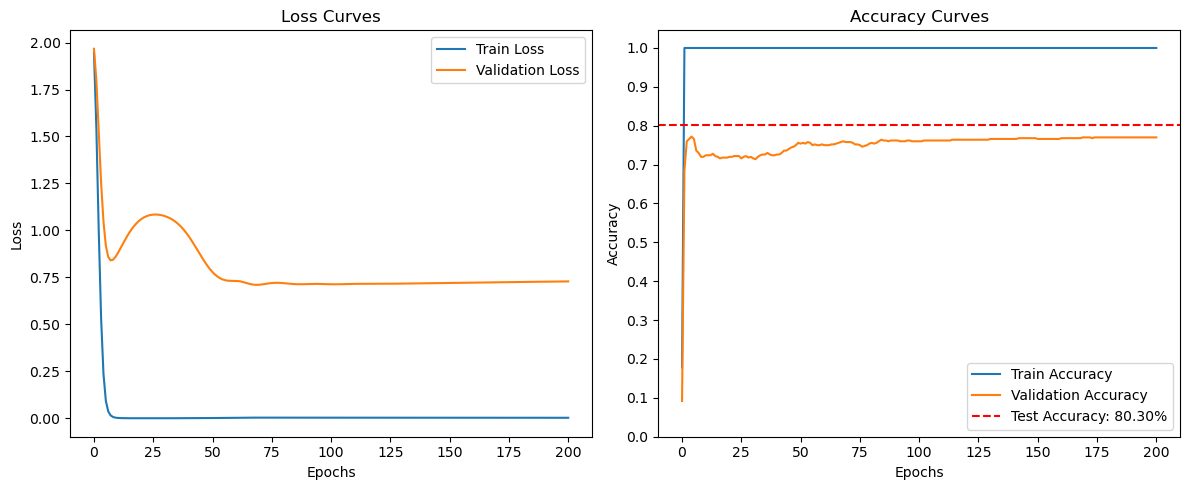

In [89]:
g_sage_gpu.fit(data.to('mps'), epochs=200)

In [90]:
g_sage_gpu.test(data.to('mps'))

0.803

## Summary of GraphSAGE

|  Device  | Train Acc | Val Acc | Test Acc |
|:--------:|:---------:|:-------:|:--------:|
|   CPU    |   100%    |  77.4%  |   80%    |
|   GPU    |   100%    |   77    |  80.3%   |
| Tesla T4 |   100%    |  77.8%  |  80.3%   |